In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pickle_file = '../dataset/arbimonTest1_augmented_7.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (705, 28, 28) (705,)
Validation set (235, 28, 28) (235,)
Test set (235, 28, 28) (235,)


In [3]:
image_size = train_dataset.shape[2]
num_channels = 1
num_labels = 21

def reformat(dataset):#, labels):
    #dataset = np.squeeze(dataset).shape
    dataset = dataset.reshape((-1, image_size, image_size, num_channels, )
                           ).astype(np.float32)
  #labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset#, labels
train_dataset = reformat(train_dataset)#, train_labels)
valid_dataset = reformat(valid_dataset)#, valid_labels)
test_dataset = reformat(test_dataset)#, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (705, 28, 28, 1) (705,)
Validation set (235, 28, 28, 1) (235,)
Test set (235, 28, 28, 1) (235,)


In [4]:
train_dataset[1].shape

(28, 28, 1)

In [5]:
import numpy as np

# Pad images with 0s
X_train      = np.pad(train_dataset, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(valid_dataset, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(test_dataset, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


In [6]:
y_train = train_labels
y_validation = valid_labels
y_test = test_labels

0


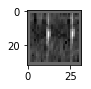

In [7]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [8]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [9]:
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 100

In [10]:
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides, padding):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k, padding):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding=padding)


def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # TODO: Activation.
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    W = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(6))
    layer1 = conv2d(x, W, b, 1, 'VALID')
    pool1 = maxpool2d(layer1, 2, 'VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    # TODO: Activation.
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    W = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(16))
    layer2 = conv2d(pool1, W, b, 1, 'VALID')
    pool2 = maxpool2d(layer2, 2, 'VALID')
    

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc = flatten(pool2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    # TODO: Activation.
    W = tf.Variable(tf.truncated_normal([400, 120], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(120))
    fc1 = tf.nn.relu(tf.add(tf.matmul(fc, W), b))

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    # TODO: Activation.
    W = tf.Variable(tf.truncated_normal([120, 84], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(84))
    fc2 = tf.nn.relu(tf.add(tf.matmul(fc1, W), b))
    

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 21.
    W = tf.Variable(tf.truncated_normal([84, 21], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(21))
    logits = tf.add(tf.matmul(fc2, W), b)
    
    return logits

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 21)

In [12]:
#rate = 0.05
rate = 0.05

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        if (i%10 == 0):
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
        
    import os
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    save_path='lenet'
    if not os.path.isabs(save_path):
        save_path = os.path.abspath(os.path.join(os.getcwd(), save_path))
    saver.save(sess, save_path)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.055



In [ ]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

## Test Accuracy w/out Augmentation: 0.300
## Test Accuracy w Augmentation: 0.828